# ARMA Model Comparison: Air Quality with and without Traffic Data

This notebook compares two modeling approaches:
1. **ARMA Model**: Using only air quality (NO₂) historical data
2. **ARMAX Model**: Using air quality data + traffic counts as exogenous variable

**Goal**: Determine if traffic data improves air quality prediction accuracy

In [4]:
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.3.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 18.1 MB/s eta 0:00:00 0:00:01
Using cached pandas-2.3.3-cp39-cp39-macosx_11_0_arm64.whl (10.8 MB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.0
    Uninstalling pandas-2.1.0:
      Successfully uninstalled pandas-2.1.0

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


## 1. Load and Prepare Data

In [5]:
# Load air quality data (from the existing workflow)
import glob
import re

# Read air quality data
all_data = []
for file_path in glob.glob("Air Quality Dataset/aq_data/*.csv"):
    with open(file_path, 'r') as f:
        meta_lines = [next(f) for _ in range(10)]
        station_name = meta_lines[1].split(',')[1].strip()
        lat = meta_lines[3].split(',')[1].strip()
        lon = meta_lines[4].split(',')[1].strip()
    
    df = pd.read_csv(file_path, skiprows=10, index_col=False)
    df['Station_Name'] = station_name
    df['Latitude'] = lat
    df['Longitude'] = lon
    all_data.append(df)

aq_df = pd.concat(all_data, ignore_index=True)
aq_df.replace([9999, -999], pd.NA, inplace=True)

# Calculate daily average NO2
hourly_cols = [f'H{i:02d}' for i in range(1, 25)]
aq_df['daily_total'] = aq_df[hourly_cols].mean(axis=1)
aq_df['Date'] = pd.to_datetime(aq_df['Date'], errors='coerce')
aq_df = aq_df.dropna(subset=['Date'])
aq_df = aq_df[aq_df['daily_total'] >= 0]

print(f"Air Quality data loaded: {len(aq_df)} records")
print(f"Date range: {aq_df['Date'].min()} to {aq_df['Date'].max()}")
print(f"\nStations: {aq_df['Station_Name'].unique()}")

Air Quality data loaded: 4360 records
Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00

Stations: ['Toronto West (35125)' 'Toronto East (33003)' 'Toronto North (34021)'
 'Toronto Downtown (31129)']


In [6]:
# Load traffic data
traffic_path = "Traffic Dataset - Statistics Canada/filtered_roads_with_sums.csv"
traffic_df = pd.read_csv(traffic_path)

# Transform traffic data to long format
date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
traffic_date_cols = [c for c in traffic_df.columns if date_col_pattern.match(str(c))]

traffic_long = []
for idx, row in traffic_df.iterrows():
    camera_road = row['camera_road']
    for col in traffic_date_cols:
        traffic_value = row[col]
        if pd.notna(traffic_value):
            date_str = col[1:]
            date = pd.to_datetime(date_str, format='%Y_%m_%d')
            traffic_long.append({
                'Date': date,
                'camera_road': camera_road,
                'traffic_count': traffic_value
            })

traffic_long_df = pd.DataFrame(traffic_long)
print(f"\nTraffic data loaded: {len(traffic_long_df)} records")
print(f"Date range: {traffic_long_df['Date'].min()} to {traffic_long_df['Date'].max()}")
print(f"\nLocations: {traffic_long_df['camera_road'].unique()}")


Traffic data loaded: 4300 records
Date range: 2022-02-03 00:00:00 to 2025-10-31 00:00:00

Locations: ['FRONT ST W / JOHN ST / PRIVATE ACCESS' 'STEELES AVE W / DUFFERIN ST'
 'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE'
 'LAWRENCE AVE E / KENNEDY RD']


In [7]:
# Create location mapping
location_mapping = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East (33003)',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North (34021)',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown (31129)',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West (35125)'
}

# Add station names to traffic data
traffic_long_df['Station_Name'] = traffic_long_df['camera_road'].map(location_mapping)

print("Location Mapping:")
for traffic_loc, aq_station in location_mapping.items():
    print(f"  {aq_station}: {traffic_loc}")

Location Mapping:
  Toronto East (33003): LAWRENCE AVE E / KENNEDY RD
  Toronto North (34021): STEELES AVE W / DUFFERIN ST
  Toronto Downtown (31129): FRONT ST W / JOHN ST / PRIVATE ACCESS
  Toronto West (35125): ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE


## 2. Prepare Data for Modeling

We'll select one station and prepare both datasets:
- Dataset 1: Air quality only
- Dataset 2: Air quality + traffic (merged)

In [28]:
# Select a station for modeling (you can change this)
# Options: 'Toronto East (33003)', 'Toronto North (34021)', 'Toronto Downtown (31129)', 'Toronto West (35125)'
selected_station = 'Toronto North (34021)'

print(f"Selected Station: {selected_station}\n")

# Filter air quality data
aq_station = aq_df[aq_df['Station_Name'] == selected_station][['Date', 'daily_total']].copy()
aq_station = aq_station.sort_values('Date').reset_index(drop=True)

# Filter traffic data
traffic_station = traffic_long_df[traffic_long_df['Station_Name'] == selected_station][['Date', 'traffic_count']].copy()
traffic_station = traffic_station.sort_values('Date').reset_index(drop=True)

print(f"Air Quality records: {len(aq_station)}")
print(f"Traffic records: {len(traffic_station)}")

# Merge datasets on Date
merged_data = pd.merge(aq_station, traffic_station, on='Date', how='inner')
merged_data = merged_data.sort_values('Date').reset_index(drop=True)

print(f"\nMerged records (overlapping dates): {len(merged_data)}")
print(f"Date range: {merged_data['Date'].min()} to {merged_data['Date'].max()}")

merged_data.head(10)

Selected Station: Toronto North (34021)

Air Quality records: 1092
Traffic records: 1112

Merged records (overlapping dates): 864
Date range: 2022-02-03 00:00:00 to 2024-12-28 00:00:00
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/pandas/core/frame.py", line 1178, in _repr_html_
    # when auto-detecting, so width=None and not in ipython front end
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/pandas/io/formats/format.py", line 1074, in to_html
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/pandas/io/formats/html.py", line 644, in render
    super().render()
  File "/Users/a1/Library/Python/3.9/lib/python/site-packages/pandas/io/formats/html.py", line 94, in rende

        Date daily_total  traffic_count
0 2022-02-03    5.154167          190.0
1 2022-02-04     10.0875          150.0
2 2022-02-05   13.920833           37.0
3 2022-02-06     10.6125           56.0
4 2022-02-07   18.545833          131.0
5 2022-02-08   18.845455          121.0
6 2022-02-09   19.916667           92.0
7 2022-02-10      12.725          238.0
8 2022-02-11     12.9875          168.0
9 2022-02-12    6.720833          399.0

In [29]:
# Check for missing values and handle them
print("Missing values in merged data:")
print(merged_data.isnull().sum())

# Remove any rows with missing values
merged_data = merged_data.dropna()

# Convert to numeric types to avoid dtype issues
merged_data['daily_total'] = pd.to_numeric(merged_data['daily_total'], errors='coerce')
merged_data['traffic_count'] = pd.to_numeric(merged_data['traffic_count'], errors='coerce')

# Remove any rows that couldn't be converted to numeric
merged_data = merged_data.dropna()

print(f"\nAfter removing NAs: {len(merged_data)} records")
print(f"\nData types:")
print(merged_data[['daily_total', 'traffic_count']].dtypes)

Missing values in merged data:
Date             0
daily_total      0
traffic_count    0
dtype: int64

After removing NAs: 864 records

Data types:
daily_total      float64
traffic_count    float64
dtype: object


## 3. Exploratory Data Analysis

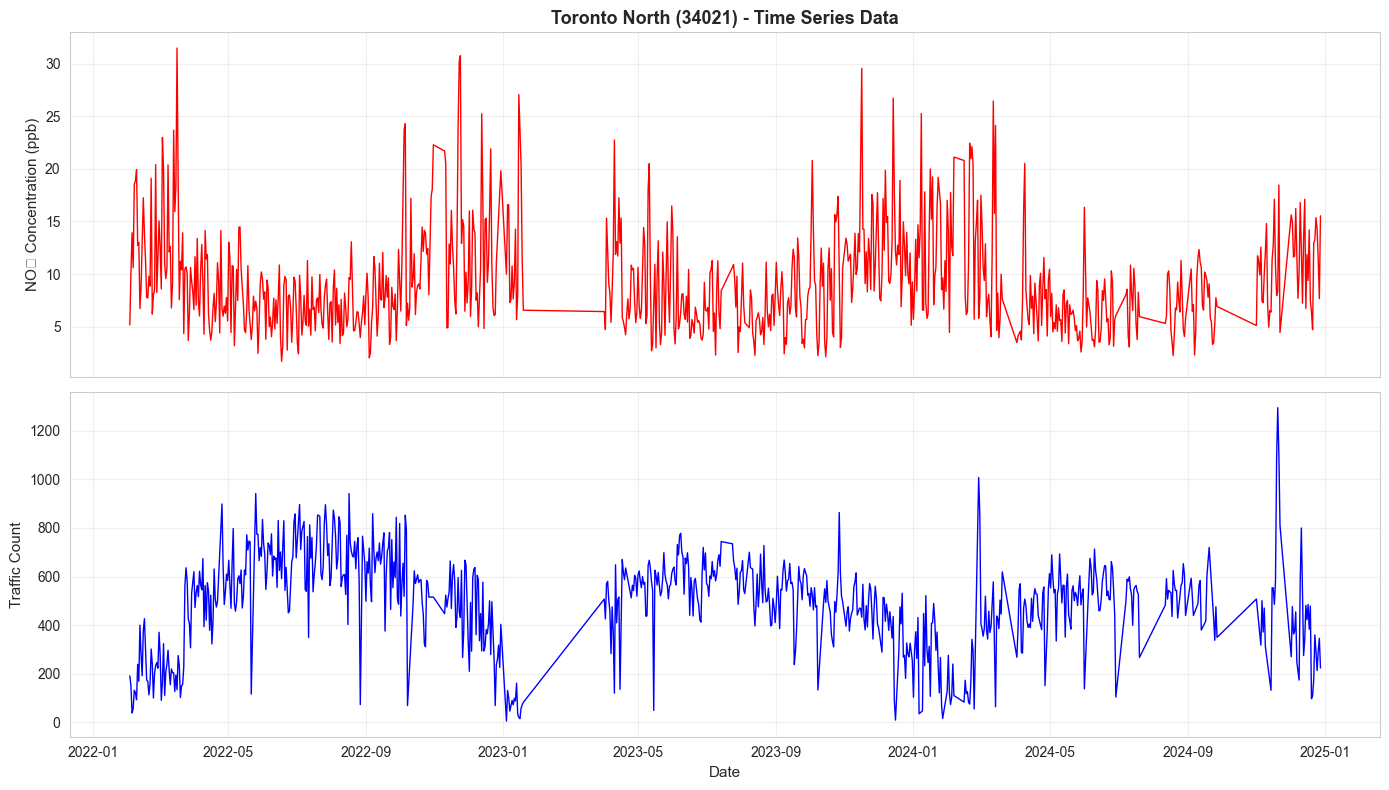


Summary Statistics:
       daily_total  traffic_count
count   864.000000     864.000000
mean      9.266555     485.310185
std       4.823302     195.190530
min       1.695833       4.000000
25%       5.769792     378.000000
50%       8.145833     516.000000
75%      11.544792     607.000000
max      31.487500    1296.000000


In [30]:
# Plot time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Air Quality
axes[0].plot(merged_data['Date'], merged_data['daily_total'], color='red', linewidth=1)
axes[0].set_ylabel('NO₂ Concentration (ppb)', fontsize=11)
axes[0].set_title(f'{selected_station} - Time Series Data', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Traffic
axes[1].plot(merged_data['Date'], merged_data['traffic_count'], color='blue', linewidth=1)
axes[1].set_ylabel('Traffic Count', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(merged_data[['daily_total', 'traffic_count']].describe())

Correlation between Traffic and NO₂: -0.2797


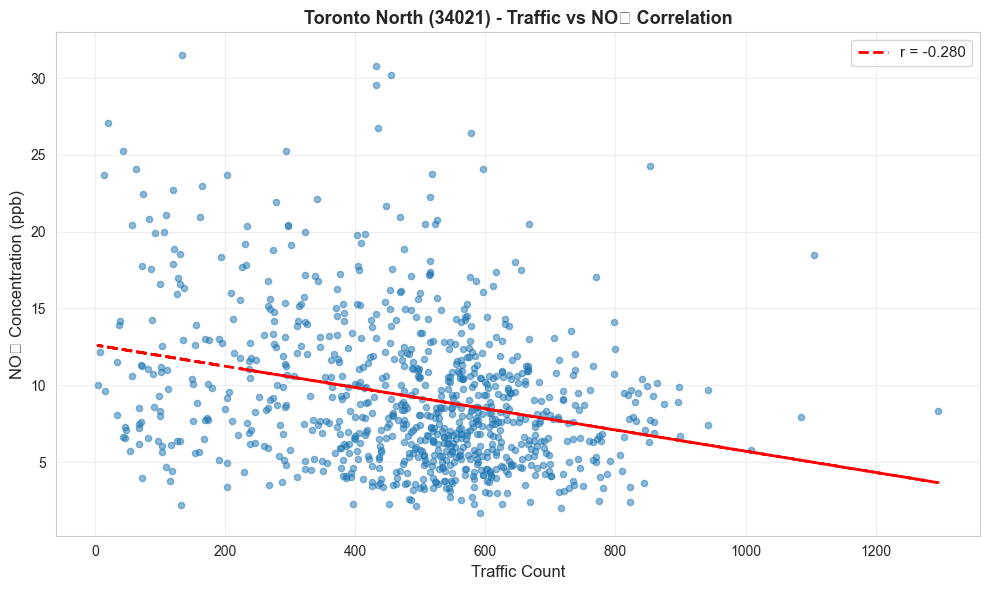

In [31]:
# Correlation analysis
correlation = merged_data['daily_total'].corr(merged_data['traffic_count'])
print(f"Correlation between Traffic and NO₂: {correlation:.4f}")

# Scatter plot
plt.figure(figsize=(10, 6))

# Convert to numpy arrays with explicit float type for polyfit
x_data = merged_data['traffic_count'].values.astype(float)
y_data = merged_data['daily_total'].values.astype(float)

plt.scatter(x_data, y_data, alpha=0.5, s=20)
z = np.polyfit(x_data, y_data, 1)
p = np.poly1d(z)
plt.plot(x_data, p(x_data), "r--", linewidth=2, label=f'r = {correlation:.3f}')

plt.xlabel('Traffic Count', fontsize=12)
plt.ylabel('NO₂ Concentration (ppb)', fontsize=12)
plt.title(f'{selected_station} - Traffic vs NO₂ Correlation', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Stationarity Check

ARMA models require stationary data. We'll use the Augmented Dickey-Fuller test.

In [32]:
def check_stationarity(series, name):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(series.dropna())
    print(f"\n{'='*60}")
    print(f"Augmented Dickey-Fuller Test: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] < 0.05:
        print(f"\n✓ Series is STATIONARY (p-value < 0.05)")
        return True
    else:
        print(f"\n✗ Series is NON-STATIONARY (p-value >= 0.05)")
        print(f"  Consider differencing the series.")
        return False

# Check stationarity of NO2
is_stationary_no2 = check_stationarity(merged_data['daily_total'], 'NO₂ Concentration')

# Check stationarity of traffic
is_stationary_traffic = check_stationarity(merged_data['traffic_count'], 'Traffic Count')


Augmented Dickey-Fuller Test: NO₂ Concentration
ADF Statistic: -2.371731
p-value: 0.149875
Critical Values:
  1%: -3.438
  5%: -2.865
  10%: -2.569

✗ Series is NON-STATIONARY (p-value >= 0.05)
  Consider differencing the series.

Augmented Dickey-Fuller Test: Traffic Count
ADF Statistic: -3.186005
p-value: 0.020809
Critical Values:
  1%: -3.438
  5%: -2.865
  10%: -2.569

✓ Series is STATIONARY (p-value < 0.05)


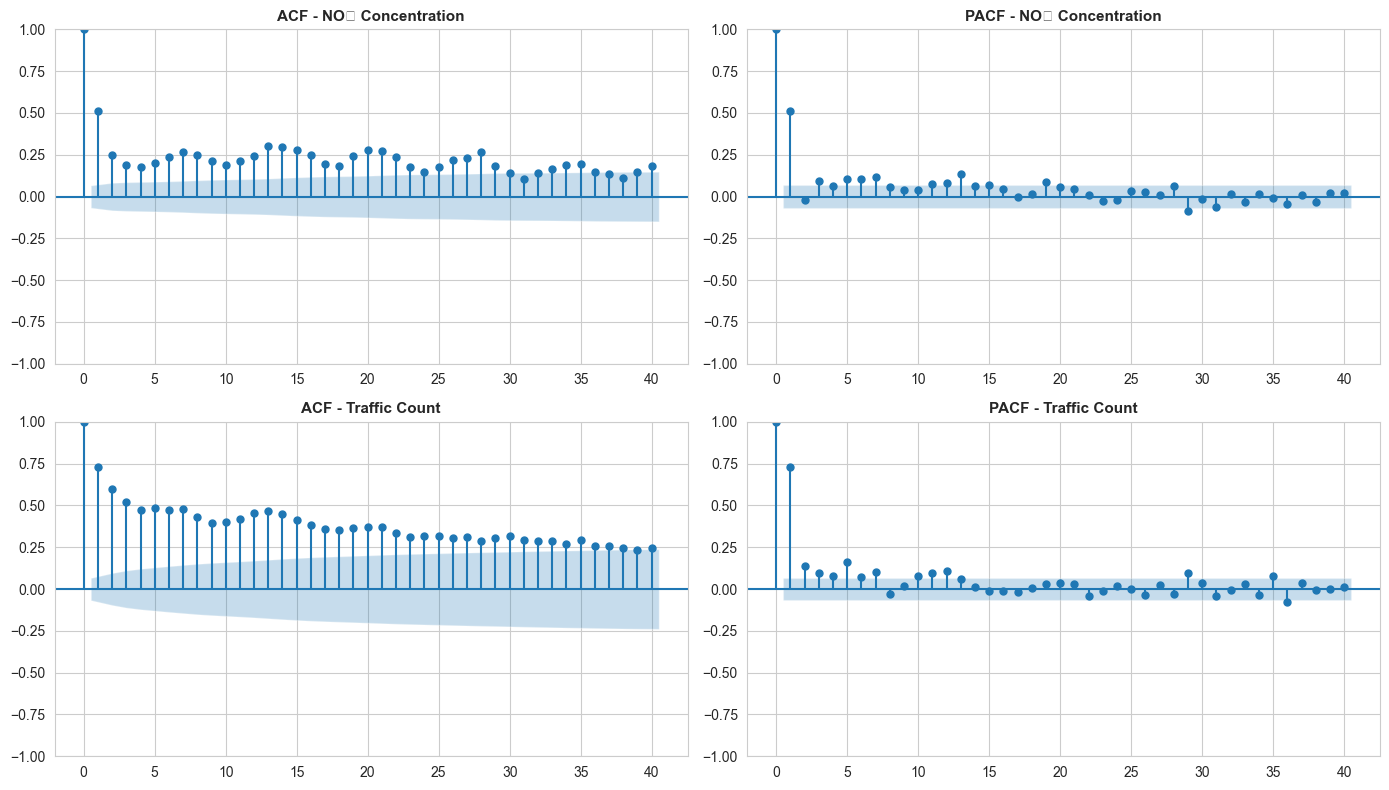


Use ACF and PACF plots to determine:
  - AR order (p): Look at PACF cutoff
  - MA order (q): Look at ACF cutoff


In [33]:
# Plot ACF and PACF to determine ARMA orders
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF for NO2
plot_acf(merged_data['daily_total'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - NO₂ Concentration', fontsize=11, fontweight='bold')

# PACF for NO2
plot_pacf(merged_data['daily_total'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - NO₂ Concentration', fontsize=11, fontweight='bold')

# ACF for Traffic
plot_acf(merged_data['traffic_count'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Traffic Count', fontsize=11, fontweight='bold')

# PACF for Traffic
plot_pacf(merged_data['traffic_count'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Traffic Count', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nUse ACF and PACF plots to determine:")
print("  - AR order (p): Look at PACF cutoff")
print("  - MA order (q): Look at ACF cutoff")

## 5. Train-Test Split

We'll use 80% for training and 20% for testing

In [34]:
# Split data into train and test sets
train_size = int(len(merged_data) * 0.8)

train_data = merged_data.iloc[:train_size].copy()
test_data = merged_data.iloc[train_size:].copy()

# Ensure data types are numeric for modeling
train_data['daily_total'] = train_data['daily_total'].astype(float)
train_data['traffic_count'] = train_data['traffic_count'].astype(float)
test_data['daily_total'] = test_data['daily_total'].astype(float)
test_data['traffic_count'] = test_data['traffic_count'].astype(float)

print(f"Total records: {len(merged_data)}")
print(f"Training set: {len(train_data)} records ({train_data['Date'].min()} to {train_data['Date'].max()})")
print(f"Test set: {len(test_data)} records ({test_data['Date'].min()} to {test_data['Date'].max()})")

Total records: 864
Training set: 691 records (2022-02-03 00:00:00 to 2024-04-21 00:00:00)
Test set: 173 records (2024-04-22 00:00:00 to 2024-12-28 00:00:00)


## 6. Model 1: ARMA (Air Quality Only)

First model uses only historical NO₂ concentrations

In [35]:
# Find optimal ARMA order using AIC/BIC
print("Finding optimal ARMA order...\n")

best_aic = np.inf
best_order = None
best_model = None

# Try different combinations of p and q
results_grid = []

for p in range(0, 6):
    for q in range(0, 6):
        try:
            # Fit ARIMA with d=0 (which is ARMA)
            model = ARIMA(train_data['daily_total'], order=(p, 0, q))
            fitted_model = model.fit()
            
            results_grid.append({
                'p': p, 'q': q,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic
            })
            
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = (p, 0, q)
                best_model = fitted_model
        except:
            continue

results_df = pd.DataFrame(results_grid)
print(f"Best ARMA order: p={best_order[0]}, q={best_order[2]}")
print(f"Best AIC: {best_aic:.2f}\n")

# Show top 10 models
print("Top 10 models by AIC:")
print(results_df.sort_values('AIC').head(10))

Finding optimal ARMA order...

Best ARMA order: p=5, q=4
Best AIC: 3944.86

Top 10 models by AIC:
    p  q          AIC          BIC
34  5  4  3944.862631  3994.782169
35  5  5  3944.944576  3999.402254
23  3  5  3947.699265  3993.080663
31  5  1  3948.853344  3985.158463
28  4  4  3948.948399  3994.329797
32  5  2  3949.559764  3990.403023
27  4  3  3949.650439  3990.493697
11  1  5  3950.341341  3986.646459
19  3  1  3950.469927  3977.698766
25  4  1  3951.185491  3982.952470


In [36]:
# Fit the best ARMA model
print(f"\n{'='*60}")
print(f"MODEL 1: ARMA({best_order[0]}, {best_order[2]}) - Air Quality Only")
print(f"{'='*60}\n")

arma_model = ARIMA(train_data['daily_total'], order=best_order)
arma_fitted = arma_model.fit()

print(arma_fitted.summary())


MODEL 1: ARMA(5, 4) - Air Quality Only

                               SARIMAX Results                                
Dep. Variable:            daily_total   No. Observations:                  691
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -1961.431
Date:                Wed, 28 Jan 2026   AIC                           3944.863
Time:                        11:20:10   BIC                           3994.782
Sample:                             0   HQIC                          3964.171
                                - 691                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9914      1.272      7.852      0.000       7.497      12.485
ar.L1          0.3871      0.079      4.903      0.000       0.232       0.542
ar.L2      

In [37]:
# Make predictions on test set
arma_forecast = arma_fitted.forecast(steps=len(test_data))

# Calculate metrics
arma_mse = mean_squared_error(test_data['daily_total'], arma_forecast)
arma_rmse = np.sqrt(arma_mse)
arma_mae = mean_absolute_error(test_data['daily_total'], arma_forecast)
arma_r2 = r2_score(test_data['daily_total'], arma_forecast)

# Calculate MAPE (Mean Absolute Percentage Error)
arma_mape = np.mean(np.abs((test_data['daily_total'].values - arma_forecast.values) / test_data['daily_total'].values)) * 100

print(f"\n{'='*60}")
print(f"MODEL 1 PERFORMANCE METRICS (Test Set)")
print(f"{'='*60}")
print(f"Mean Squared Error (MSE):     {arma_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {arma_rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {arma_mae:.4f}")
print(f"R² Score:                     {arma_r2:.4f}")
print(f"Mean Absolute % Error (MAPE): {arma_mape:.2f}%")
print(f"\nModel Information Criteria:")
print(f"AIC:                          {arma_fitted.aic:.2f}")
print(f"BIC:                          {arma_fitted.bic:.2f}")


MODEL 1 PERFORMANCE METRICS (Test Set)
Mean Squared Error (MSE):     12.5968
Root Mean Squared Error (RMSE): 3.5492
Mean Absolute Error (MAE):    2.9652
R² Score:                     -0.0272
Mean Absolute % Error (MAPE): 53.33%

Model Information Criteria:
AIC:                          3944.86
BIC:                          3994.78


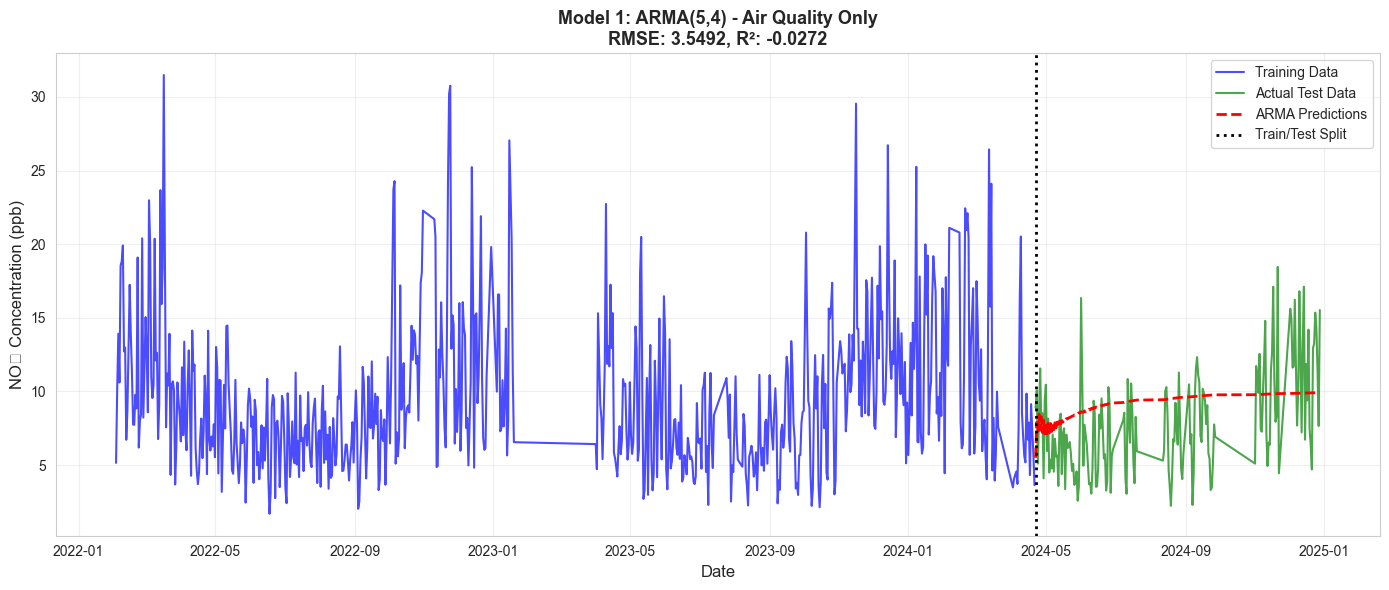

In [38]:
# Plot predictions
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data['Date'], train_data['daily_total'], 
         label='Training Data', color='blue', linewidth=1.5, alpha=0.7)

# Plot actual test data
plt.plot(test_data['Date'], test_data['daily_total'], 
         label='Actual Test Data', color='green', linewidth=1.5, alpha=0.7)

# Plot predictions
plt.plot(test_data['Date'], arma_forecast, 
         label='ARMA Predictions', color='red', linewidth=2, linestyle='--')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date', fontsize=12)
plt.ylabel('NO₂ Concentration (ppb)', fontsize=12)
plt.title(f'Model 1: ARMA({best_order[0]},{best_order[2]}) - Air Quality Only\nRMSE: {arma_rmse:.4f}, R²: {arma_r2:.4f}', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Model 2: ARMAX (Air Quality + Traffic)

Second model uses NO₂ concentrations plus traffic counts as exogenous variable

In [39]:
# Find optimal ARMAX order using AIC/BIC
print("Finding optimal ARMAX order...\n")

best_aic_x = np.inf
best_order_x = None
best_model_x = None

# Try different combinations of p and q
results_grid_x = []

for p in range(0, 6):
    for q in range(0, 6):
        try:
            # Fit ARIMA with exogenous variable (traffic)
            model = ARIMA(train_data['daily_total'], 
                         exog=train_data[['traffic_count']], 
                         order=(p, 0, q))
            fitted_model = model.fit()
            
            results_grid_x.append({
                'p': p, 'q': q,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic
            })
            
            if fitted_model.aic < best_aic_x:
                best_aic_x = fitted_model.aic
                best_order_x = (p, 0, q)
                best_model_x = fitted_model
        except:
            continue

results_df_x = pd.DataFrame(results_grid_x)
print(f"Best ARMAX order: p={best_order_x[0]}, q={best_order_x[2]}")
print(f"Best AIC: {best_aic_x:.2f}\n")

# Show top 10 models
print("Top 10 models by AIC:")
print(results_df_x.sort_values('AIC').head(10))

Finding optimal ARMAX order...

Best ARMAX order: p=5, q=5
Best AIC: 3951.34

Top 10 models by AIC:
    p  q          AIC          BIC
35  5  5  3951.335618  4010.331435
29  4  5  3956.717123  4011.174801
33  5  3  3958.223388  4008.142926
16  2  4  3961.412678  4002.255936
22  3  4  3963.140554  4008.521952
17  2  5  3971.744534  4017.125932
11  1  5  3978.626501  4019.469760
32  5  2  3978.920541  4024.301939
34  5  4  3982.294037  4036.751715
28  4  4  3983.926049  4033.845587


In [40]:
# Fit the best ARMAX model
print(f"\n{'='*60}")
print(f"MODEL 2: ARMAX({best_order_x[0]}, {best_order_x[2]}) - Air Quality + Traffic")
print(f"{'='*60}\n")

armax_model = ARIMA(train_data['daily_total'], 
                    exog=train_data[['traffic_count']], 
                    order=best_order_x)
armax_fitted = armax_model.fit()

print(armax_fitted.summary())


MODEL 2: ARMAX(5, 5) - Air Quality + Traffic

                               SARIMAX Results                                
Dep. Variable:            daily_total   No. Observations:                  691
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -1962.668
Date:                Wed, 28 Jan 2026   AIC                           3951.336
Time:                        11:20:39   BIC                           4010.331
Sample:                             0   HQIC                          3974.155
                                - 691                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.1305      2.004      6.552      0.000       9.203      17.058
traffic_count    -0.0022      0.001     -1.900      0.057      -0.004    6.

In [41]:
# Make predictions on test set
armax_forecast = armax_fitted.forecast(steps=len(test_data), 
                                        exog=test_data[['traffic_count']])

# Calculate metrics
armax_mse = mean_squared_error(test_data['daily_total'], armax_forecast)
armax_rmse = np.sqrt(armax_mse)
armax_mae = mean_absolute_error(test_data['daily_total'], armax_forecast)
armax_r2 = r2_score(test_data['daily_total'], armax_forecast)
armax_mape = np.mean(np.abs((test_data['daily_total'].values - armax_forecast.values) / test_data['daily_total'].values)) * 100

print(f"\n{'='*60}")
print(f"MODEL 2 PERFORMANCE METRICS (Test Set)")
print(f"{'='*60}")
print(f"Mean Squared Error (MSE):     {armax_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {armax_rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {armax_mae:.4f}")
print(f"R² Score:                     {armax_r2:.4f}")
print(f"Mean Absolute % Error (MAPE): {armax_mape:.2f}%")
print(f"\nModel Information Criteria:")
print(f"AIC:                          {armax_fitted.aic:.2f}")
print(f"BIC:                          {armax_fitted.bic:.2f}")


MODEL 2 PERFORMANCE METRICS (Test Set)
Mean Squared Error (MSE):     15.1417
Root Mean Squared Error (RMSE): 3.8912
Mean Absolute Error (MAE):    3.2554
R² Score:                     -0.2348
Mean Absolute % Error (MAPE): 61.56%

Model Information Criteria:
AIC:                          3951.34
BIC:                          4010.33


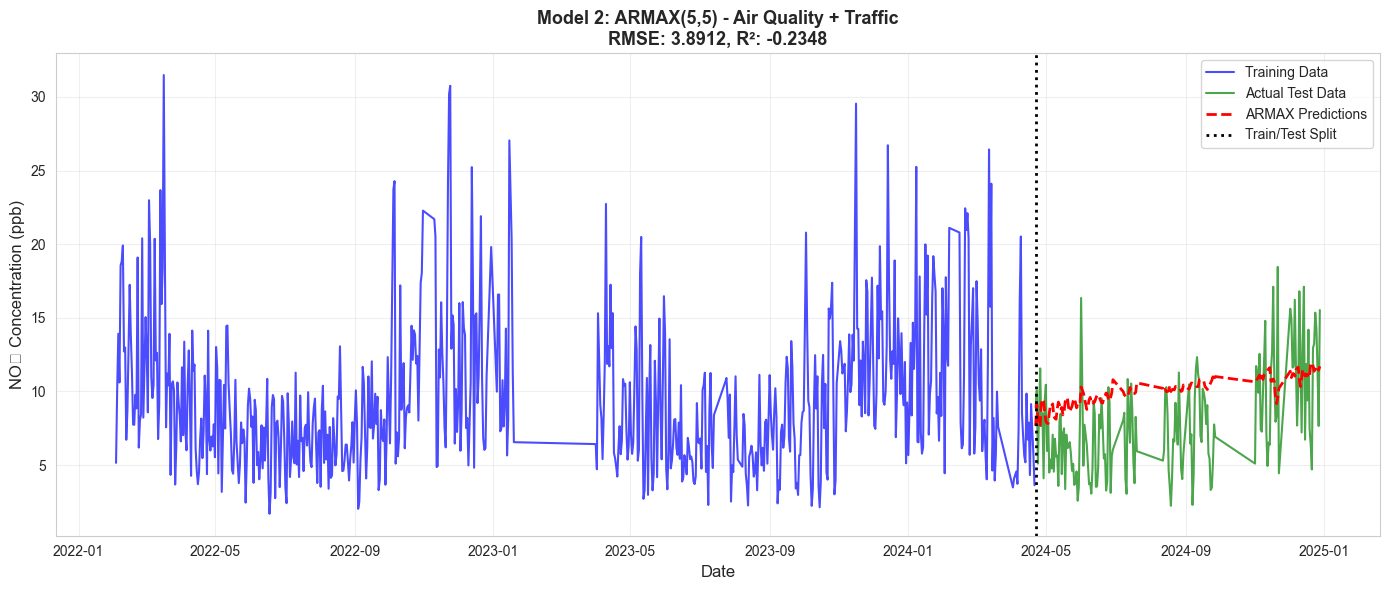

In [42]:
# Plot predictions
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data['Date'], train_data['daily_total'], 
         label='Training Data', color='blue', linewidth=1.5, alpha=0.7)

# Plot actual test data
plt.plot(test_data['Date'], test_data['daily_total'], 
         label='Actual Test Data', color='green', linewidth=1.5, alpha=0.7)

# Plot predictions
plt.plot(test_data['Date'], armax_forecast, 
         label='ARMAX Predictions', color='red', linewidth=2, linestyle='--')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date', fontsize=12)
plt.ylabel('NO₂ Concentration (ppb)', fontsize=12)
plt.title(f'Model 2: ARMAX({best_order_x[0]},{best_order_x[2]}) - Air Quality + Traffic\nRMSE: {armax_rmse:.4f}, R²: {armax_r2:.4f}', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Model Comparison

Direct comparison of both models to see if traffic data improves predictions

In [43]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R² Score', 'MAPE (%)', 'AIC', 'BIC'],
    'Model 1 (ARMA - AQ Only)': [
        f"{arma_rmse:.4f}",
        f"{arma_mae:.4f}",
        f"{arma_r2:.4f}",
        f"{arma_mape:.2f}",
        f"{arma_fitted.aic:.2f}",
        f"{arma_fitted.bic:.2f}"
    ],
    'Model 2 (ARMAX - AQ + Traffic)': [
        f"{armax_rmse:.4f}",
        f"{armax_mae:.4f}",
        f"{armax_r2:.4f}",
        f"{armax_mape:.2f}",
        f"{armax_fitted.aic:.2f}",
        f"{armax_fitted.bic:.2f}"
    ]
})

# Calculate improvement
rmse_improvement = ((arma_rmse - armax_rmse) / arma_rmse) * 100
mae_improvement = ((arma_mae - armax_mae) / arma_mae) * 100
r2_improvement = ((armax_r2 - arma_r2) / abs(arma_r2)) * 100 if arma_r2 != 0 else 0
mape_improvement = ((arma_mape - armax_mape) / arma_mape) * 100

comparison_df['Improvement (%)'] = [
    f"{rmse_improvement:.2f}%",
    f"{mae_improvement:.2f}%",
    f"{r2_improvement:.2f}%",
    f"{mape_improvement:.2f}%",
    f"{((arma_fitted.aic - armax_fitted.aic) / arma_fitted.aic * 100):.2f}%",
    f"{((arma_fitted.bic - armax_fitted.bic) / arma_fitted.bic * 100):.2f}%"
]

print(f"\n{'='*80}")
print(f"MODEL COMPARISON - {selected_station}")
print(f"{'='*80}\n")
print(comparison_df.to_string(index=False))

print(f"\n{'='*80}")
print(f"INTERPRETATION")
print(f"{'='*80}")
print(f"\nLower is better for: RMSE, MAE, MAPE, AIC, BIC")
print(f"Higher is better for: R² Score")

if armax_rmse < arma_rmse:
    print(f"\n✓ Model 2 (ARMAX) has {rmse_improvement:.2f}% better RMSE")
    print(f"  Adding traffic data IMPROVED prediction accuracy!")
else:
    print(f"\n✗ Model 1 (ARMA) performs better")
    print(f"  Adding traffic data did NOT improve predictions")


MODEL COMPARISON - Toronto North (34021)

  Metric Model 1 (ARMA - AQ Only) Model 2 (ARMAX - AQ + Traffic) Improvement (%)
    RMSE                   3.5492                         3.8912          -9.64%
     MAE                   2.9652                         3.2554          -9.79%
R² Score                  -0.0272                        -0.2348        -762.06%
MAPE (%)                    53.33                          61.56         -15.42%
     AIC                  3944.86                        3951.34          -0.16%
     BIC                  3994.78                        4010.33          -0.39%

INTERPRETATION

Lower is better for: RMSE, MAE, MAPE, AIC, BIC
Higher is better for: R² Score

✗ Model 1 (ARMA) performs better
  Adding traffic data did NOT improve predictions


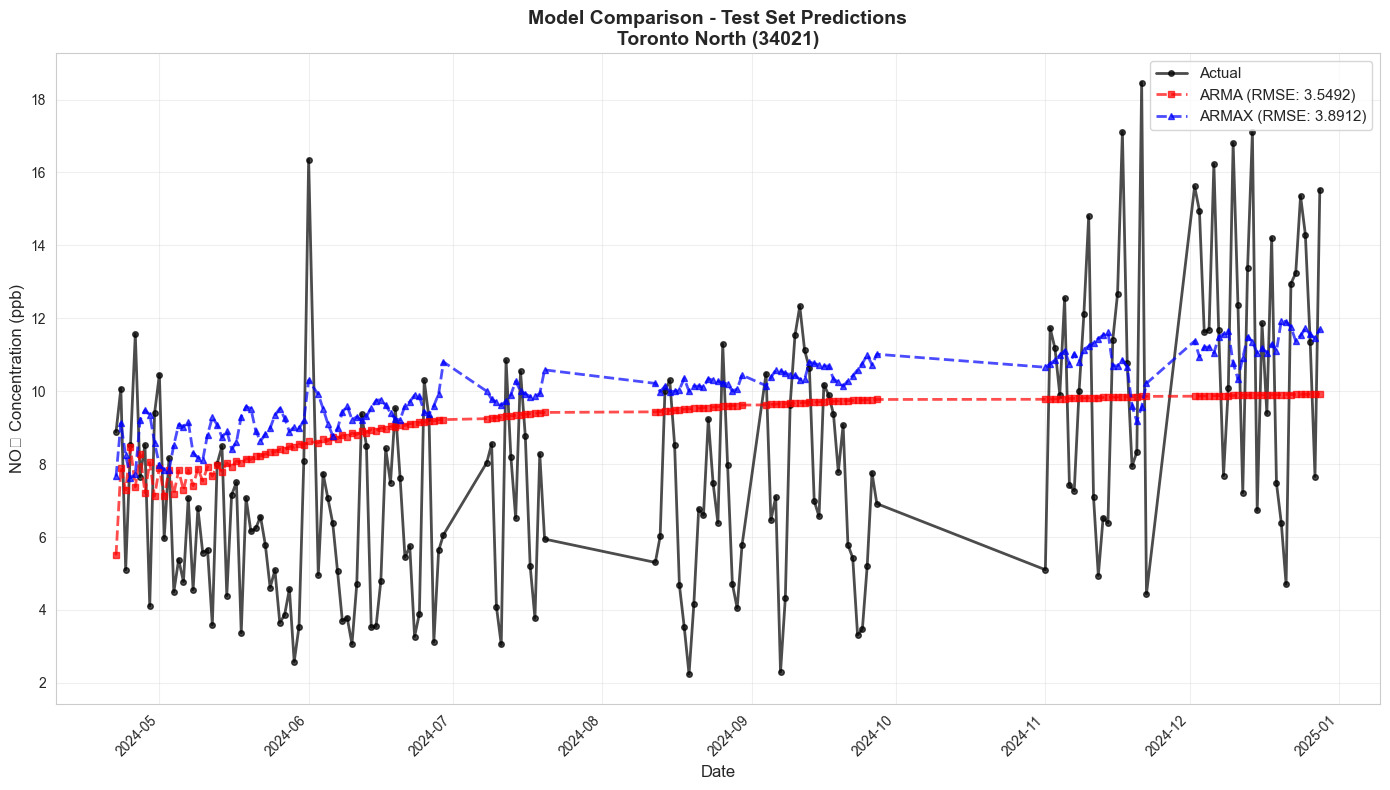

In [44]:
# Visual comparison of predictions
plt.figure(figsize=(14, 8))

# Plot actual test data
plt.plot(test_data['Date'], test_data['daily_total'], 
         label='Actual', color='black', linewidth=2, marker='o', markersize=4, alpha=0.7)

# Plot ARMA predictions
plt.plot(test_data['Date'], arma_forecast, 
         label=f'ARMA (RMSE: {arma_rmse:.4f})', 
         color='red', linewidth=2, linestyle='--', marker='s', markersize=4, alpha=0.7)

# Plot ARMAX predictions
plt.plot(test_data['Date'], armax_forecast, 
         label=f'ARMAX (RMSE: {armax_rmse:.4f})', 
         color='blue', linewidth=2, linestyle='--', marker='^', markersize=4, alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('NO₂ Concentration (ppb)', fontsize=12)
plt.title(f'Model Comparison - Test Set Predictions\n{selected_station}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

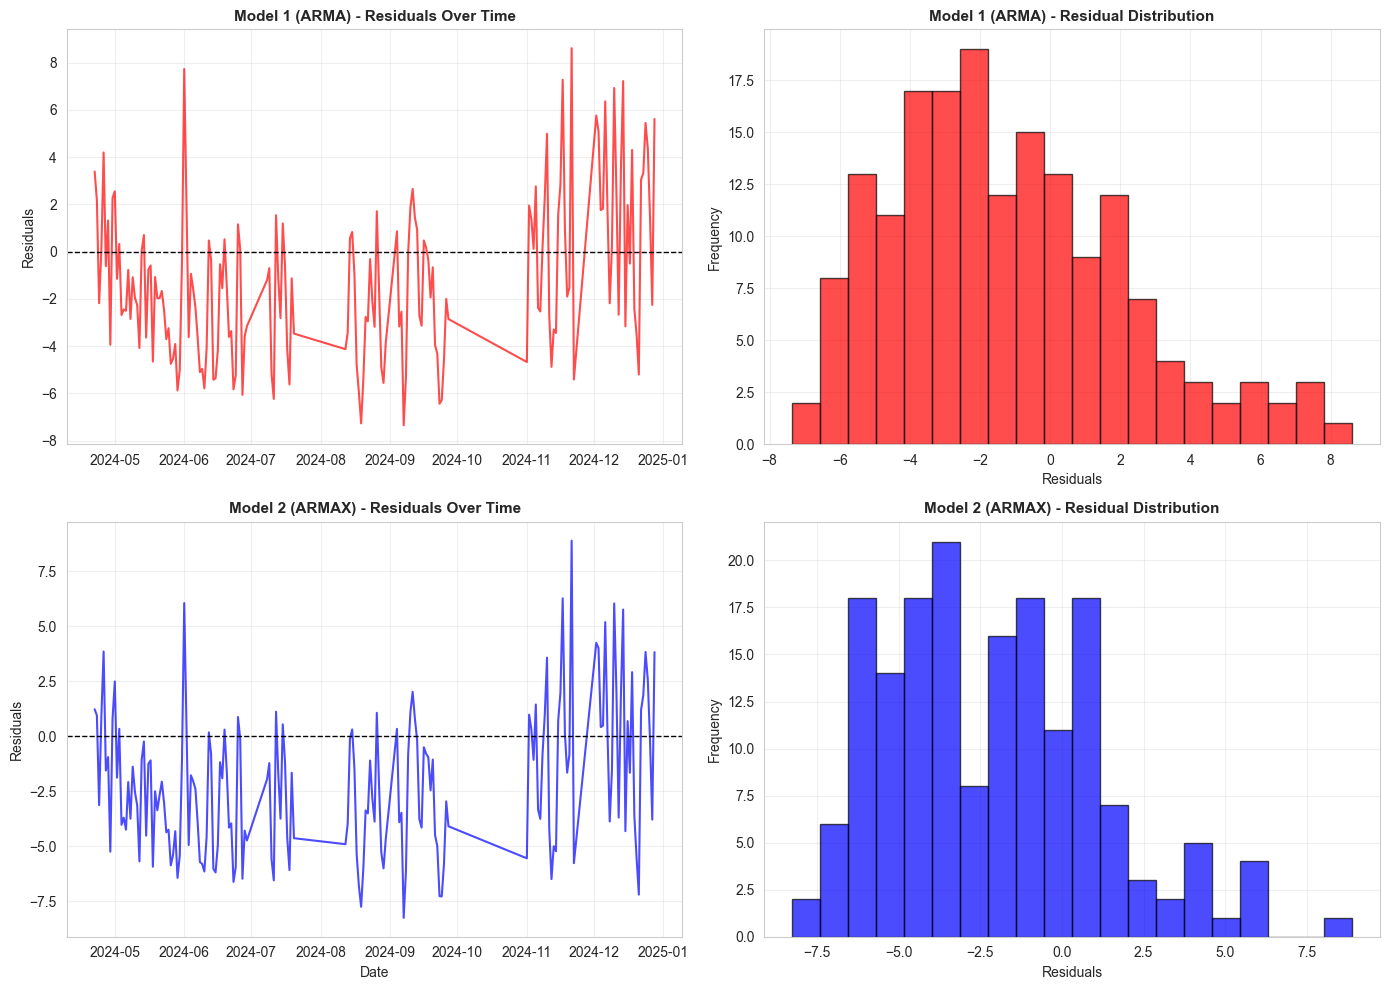

Residual Statistics:

Model 1 (ARMA):
  Mean: -1.2490
  Std Dev: 3.3222

Model 2 (ARMAX):
  Mean: -2.1294
  Std Dev: 3.2569


In [45]:
# Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ARMA residuals
arma_residuals = test_data['daily_total'].values - arma_forecast.values
axes[0, 0].plot(test_data['Date'], arma_residuals, color='red', alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Model 1 (ARMA) - Residuals Over Time', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(arma_residuals, bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Model 1 (ARMA) - Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# ARMAX residuals
armax_residuals = test_data['daily_total'].values - armax_forecast.values
axes[1, 0].plot(test_data['Date'], armax_residuals, color='blue', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Model 2 (ARMAX) - Residuals Over Time', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(armax_residuals, bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Model 2 (ARMAX) - Residual Distribution', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"\nModel 1 (ARMA):")
print(f"  Mean: {np.mean(arma_residuals):.4f}")
print(f"  Std Dev: {np.std(arma_residuals):.4f}")
print(f"\nModel 2 (ARMAX):")
print(f"  Mean: {np.mean(armax_residuals):.4f}")
print(f"  Std Dev: {np.std(armax_residuals):.4f}")

## 9. Summary and Conclusions

In [46]:
print(f"\n{'='*80}")
print(f"FINAL SUMMARY - {selected_station}")
print(f"{'='*80}\n")

print(f"Model 1: ARMA({best_order[0]}, {best_order[2]}) - Air Quality Only")
print(f"  - Uses only historical NO₂ concentrations")
print(f"  - RMSE: {arma_rmse:.4f}")
print(f"  - R²: {arma_r2:.4f}")
print(f"  - AIC: {arma_fitted.aic:.2f}\n")

print(f"Model 2: ARMAX({best_order_x[0]}, {best_order_x[2]}) - Air Quality + Traffic")
print(f"  - Uses NO₂ concentrations + traffic counts")
print(f"  - RMSE: {armax_rmse:.4f}")
print(f"  - R²: {armax_r2:.4f}")
print(f"  - AIC: {armax_fitted.aic:.2f}\n")

print(f"Performance Improvement with Traffic Data:")
print(f"  - RMSE improved by: {rmse_improvement:.2f}%")
print(f"  - MAE improved by: {mae_improvement:.2f}%")
print(f"  - R² improved by: {r2_improvement:.2f}%")
print(f"  - MAPE improved by: {mape_improvement:.2f}%\n")

if rmse_improvement > 0:
    print(f"✓ CONCLUSION: Traffic data IMPROVES air quality predictions")
    print(f"  The ARMAX model performs better, suggesting traffic volume")
    print(f"  is a useful predictor of NO₂ concentration.")
else:
    print(f"✗ CONCLUSION: Traffic data does NOT improve predictions")
    print(f"  The ARMA model performs better or equally well.")
    print(f"  Traffic volume may not be a strong predictor at this location.")

print(f"\n{'='*80}\n")


FINAL SUMMARY - Toronto North (34021)

Model 1: ARMA(5, 4) - Air Quality Only
  - Uses only historical NO₂ concentrations
  - RMSE: 3.5492
  - R²: -0.0272
  - AIC: 3944.86

Model 2: ARMAX(5, 5) - Air Quality + Traffic
  - Uses NO₂ concentrations + traffic counts
  - RMSE: 3.8912
  - R²: -0.2348
  - AIC: 3951.34

Performance Improvement with Traffic Data:
  - RMSE improved by: -9.64%
  - MAE improved by: -9.79%
  - R² improved by: -762.06%
  - MAPE improved by: -15.42%

✗ CONCLUSION: Traffic data does NOT improve predictions
  The ARMA model performs better or equally well.
  Traffic volume may not be a strong predictor at this location.




## 10. Try Different Stations (Optional)

You can run this analysis for different stations by changing the `selected_station` variable in Cell 5 and re-running all cells from there.

Available stations:
- `'Toronto East (33003)'`
- `'Toronto North (34021)'`
- `'Toronto Downtown (31129)'`
- `'Toronto West (35125)'`